In [1]:
import matplotlib
%matplotlib inline
import pandas as pd

In [2]:
data = pd.read_csv("movie_data_include_date.csv", header=None, names=['review', 'rate', 'date', 'title']) #read data

In [4]:
for ix, name in enumerate(data.columns):
    print(ix,name)

0 review
1 rate
2 date
3 title


In [5]:
data.head()

,review,rate,date,title
0,돈 들인건 티가 나지만 보는 내내 하품만,1,2018.10.29,인피니티 워
1,몰입할수밖에 없다. 어렵게 생각할 필요없다. 내가 전투에 참여한듯 손에 땀이남.,10,2018.10.26,인피니티 워
2,이전 작품에 비해 더 화려하고 스케일도 커졌지만.... 전국 맛집의 음식들을 한데 ...,8,2018.10.24,인피니티 워
3,이 정도면 볼만하다고 할 수 있음!,8,2018.10.22,인피니티 워
4,재미있다,10,2018.10.20,인피니티 워


In [13]:
data.review.shape
type(data.review)

pandas.core.series.Series

In [6]:
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()

def tokenizer(str):
    return [token for token in twitter_tag.nouns(str) if len(token) > 1]

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=tokenizer, #우선은 명사만 사용
                      decode_error ='ignore', 
                      max_df=0.5, #너무 자주 나타나는 단어는 제외, 책에서는 0.15를 사용
                      #min_df = 3, #3개 미만의 문서에서 나타난 단어는 제외, 여기서는 max_features를 1000으로 제한하므로 별 필요 없음
                      max_features = 1000) #적당한 대상 단어 수를 선택
review_cv = vec.fit_transform(data.review)

In [9]:
review_cv.shape

(14725, 1000)

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수를 지정
                                max_iter=25, #max_iter는 최종 모형에서는 5,000~10,000번 시도한다고 알려져 있음
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                #topic_word_prior: beta, doc_topic_prior: alpha
                                #일반적으로 beta는 0.1로 고정하고 alpha를 50/topic의 수 근처의 값을 시도
                                #alpha와 beta는 낮은 값을 사용할수록 특정 토픽들이 두드러지도록 하는 효과가 있다고 합
                                learning_method='batch', #'batch'는 'online'에 비해 더 성능이 좋고 느림, 현재는 default
                                n_jobs= -1, #사용 processor 수, None이면 1, -1이면 모두 사용
                                random_state=0)

review_topics = lda.fit_transform(review_cv)

In [14]:
print(review_topics.shape)
type(review_topics)

(14725, 10)


numpy.ndarray

In [31]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

In [32]:
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 감동, 스토리, 기대, 내용, 원작, 신파, 별로, 웹툰, 억지, 나름
Topic #1: 마블, 영화, 노스, 다음, 이해, 결말, 사람, 어벤져스, 다른, 이영화
Topic #2: 마지막, 장면, 영화, 감독, 부분, 송강호, 하나, 모두, 작품, 때문
Topic #3: 진짜, 사람, 광주, 역사, 가슴, 우리, 영화, 정도, 지금, 사실
Topic #4: 영화, 보고, 그냥, 느낌, 처음, 차태현, 몰입, 관객, 천만, 최악
Topic #5: 영화, 정말, 최고, 시간, 사랑, 이야기, 현실, 연기력, 내내, 노래
Topic #6: 영화, 재미, 중간, 액션, 인생, 음악, 조금, 한국영, 이상, 이건
Topic #7: 생각, 눈물, 영화, 평점, 가족, 마음, 기억, 공포, 개인, 소재
Topic #8: 연기, 배우, 마동석, 윤계상, 한번, 영화, 대박, 조연, 간만, 제대로
Topic #9: 영화, 공포영화, 완전, 추천, 수준, 보기, 아이, 소리, 아주, 초반



In [16]:
trend_data = pd.DataFrame(review_topics, columns=['topic'+str(i) for i in range(1, 11)])

In [17]:
trend_data.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,0.083333,0.083333,0.083333,0.085311,0.083333,0.164689,0.083333,0.083333,0.166666,0.083333
1,0.083723,0.083474,0.083334,0.083411,0.166802,0.083595,0.083333,0.165567,0.083340,0.083421
2,0.061584,0.173710,0.235294,0.058824,0.117647,0.058824,0.117646,0.058824,0.058824,0.058824
3,0.099239,0.092669,0.092461,0.131794,0.118299,0.090909,0.093102,0.092915,0.094937,0.093676
4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [18]:
trend_data = pd.concat([trend_data, data.date], axis=1)

In [19]:
trend_data.shape

(14725, 11)

In [20]:
trend_data.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,date
0,0.083333,0.083333,0.083333,0.085311,0.083333,0.164689,0.083333,0.083333,0.166666,0.083333,2018.10.29
1,0.083723,0.083474,0.083334,0.083411,0.166802,0.083595,0.083333,0.165567,0.083340,0.083421,2018.10.26
2,0.061584,0.173710,0.235294,0.058824,0.117647,0.058824,0.117646,0.058824,0.058824,0.058824,2018.10.24
3,0.099239,0.092669,0.092461,0.131794,0.118299,0.090909,0.093102,0.092915,0.094937,0.093676,2018.10.22
4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,2018.10.20


In [21]:
trend = trend_data.groupby(['date']).mean()

In [22]:
trend.shape

(640, 10)

In [23]:
trend.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
date,,,,,,,,,,
2016.04.27,0.058937,0.121592,0.183709,0.119867,0.133412,0.132233,0.069292,0.060609,0.059982,0.060365
2016.05.09,0.222664,0.094689,0.062157,0.073525,0.099670,0.090430,0.073010,0.109788,0.112156,0.061910
2016.05.20,0.312563,0.062557,0.062500,0.125000,0.070916,0.062500,0.062572,0.062500,0.116392,0.062500
2016.06.04,0.083333,0.083510,0.163403,0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.086420
2016.07.09,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [24]:
len(set(trend_data.date))

640

In [26]:
#jupyter에서 matplotlib을 사용해 만든 graph를 화면에 표시하기 위해 필요
%matplotlib inline 

import matplotlib.pyplot as plt

#아래는 한글을 사용할 때 깨지는 문제에 대한 해결
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#그래프의 축 등에서 음수를 표시할 때 minus sign이 깨지는 것 해결
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

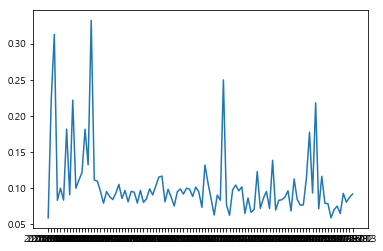

In [30]:
plt.plot(trend.index[:100], trend.topic1[:100])
plt.show()